### Import libraries

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas import DataFrame
from keras import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

### Utility functions 

In [36]:
def split_train_validate_test(df: DataFrame, train_percent=.6, validate_percent=.2, test_percent=.2):
    df.sort_values(by="Date", inplace=True) 
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[:train_end]
    validate = df.iloc[train_end:validate_end]
    test = df.iloc[validate_end:]
    
    return train, validate, test

def load_data():
    df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
    df.sort_values(by="Date", inplace=True)
    return df

def plot_gbp_usd(data):
    plt.figure(figsize=(14, 7))
    plt.title('GBPUSD Exchange Rate')
    plt.ylabel('Price GBP-USD')

    colors = plt.cm.tab10.colors  # Use a colormap for distinct colors

    # Iterate through each dataset in the array
    for idx, dataset in enumerate(data):
        dates = dataset[0]
        prices = dataset[1]
        label = data[idx][2]
        plt.plot(dates, prices, label=f'{label}', color=colors[idx % len(colors)], alpha=0.7, linewidth=2 if 'actual' in label.lower() else 1)

    plt.xticks(pd.date_range(start=min(dates), end=max(dates), freq='3MS'), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

def pre_process_data(df: DataFrame):
    # Decompose the 'Open' column into trend, seasonality, and noise
    decomp = seasonal_decompose(df["Open"], model='additive', period=30)
    df["Trend"] = decomp.trend.bfill().ffill()
    df["Seasonality"] = decomp.seasonal.bfill().ffill()
    df["Noise"] = decomp.resid.bfill().ffill()

    # Extract temporal features
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    return df

def plot_pre_processed_data(df: DataFrame):
    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(df["Date"], df["Open"], label="Original", color="blue")
    plt.title("Original Data")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(df["Date"], df["Trend"], label="Trend", color="orange")
    plt.title("Trend")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(df["Date"], df["Seasonality"], label="Seasonality", color="green")
    plt.title("Seasonality")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(df["Date"], df["Noise"], label="Noise", color="red")
    plt.title("Noise")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_train_val_evaluation_history(t, v, type="MAE"):
    plt.figure(figsize=(12, 6))
    plt.plot(t, label=f'Training {type}', color='blue')
    plt.plot(v, label=f'Validation {type}', color='orange')
    plt.title(f"Training and Validation {type}")
    plt.xlabel('Epochs')
    plt.ylabel(f'Mean {"Absolute" if type == "MAE" else "Squared"} Error ({type})')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_evaluation_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true.values - y_pred.flatten()) / y_true.values)) * 100
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"R^2 Score: {r2:.3f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.3f}%")
    return {"MAE": mae, "MSE": mse, "R Square": r2, "MAPE": mape}

def time_sequence_generator(feature, target, time_step):
    X = []
    y = []
    # Iterate over data to create sequences
    for i in range(time_step, len(feature)):
        X.append(feature[i - time_step:i])  
        y.append(target[i])  
    
    return np.array(X), np.array(y)

# 1. Visualize the data

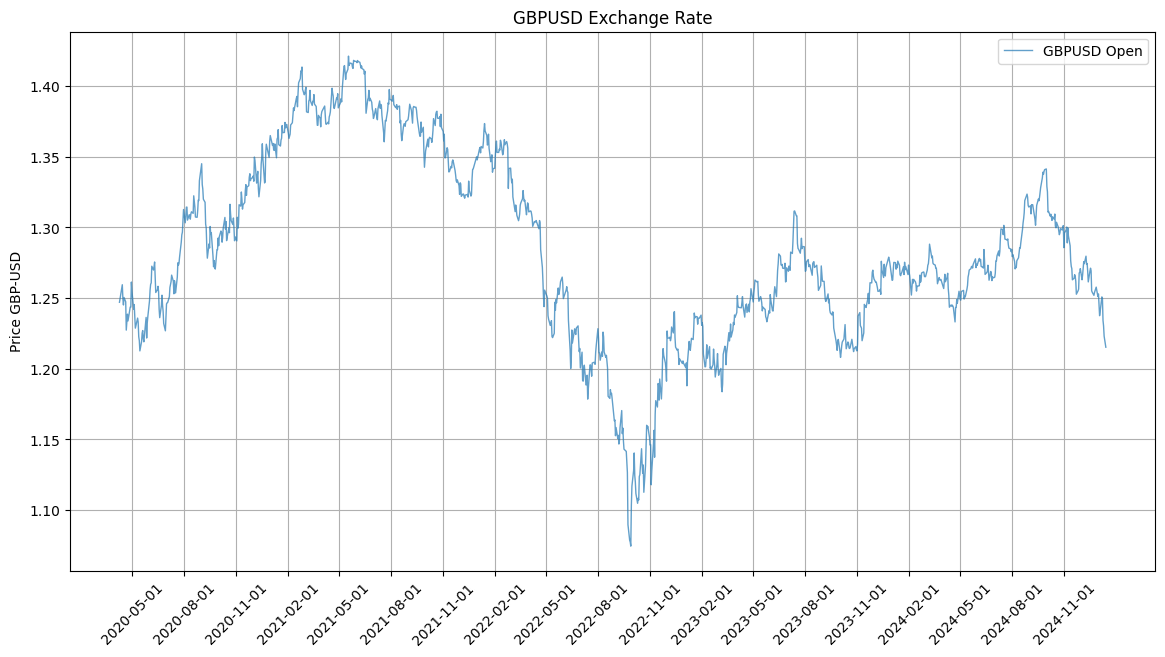

In [37]:
data = load_data()
plot_gbp_usd([[data['Date'], data['Open'], "GBPUSD Open"]])

# 2. Pre-process the data
Dissect temporal information like Trend, Seasonality, Noise, Day, Week & Month   

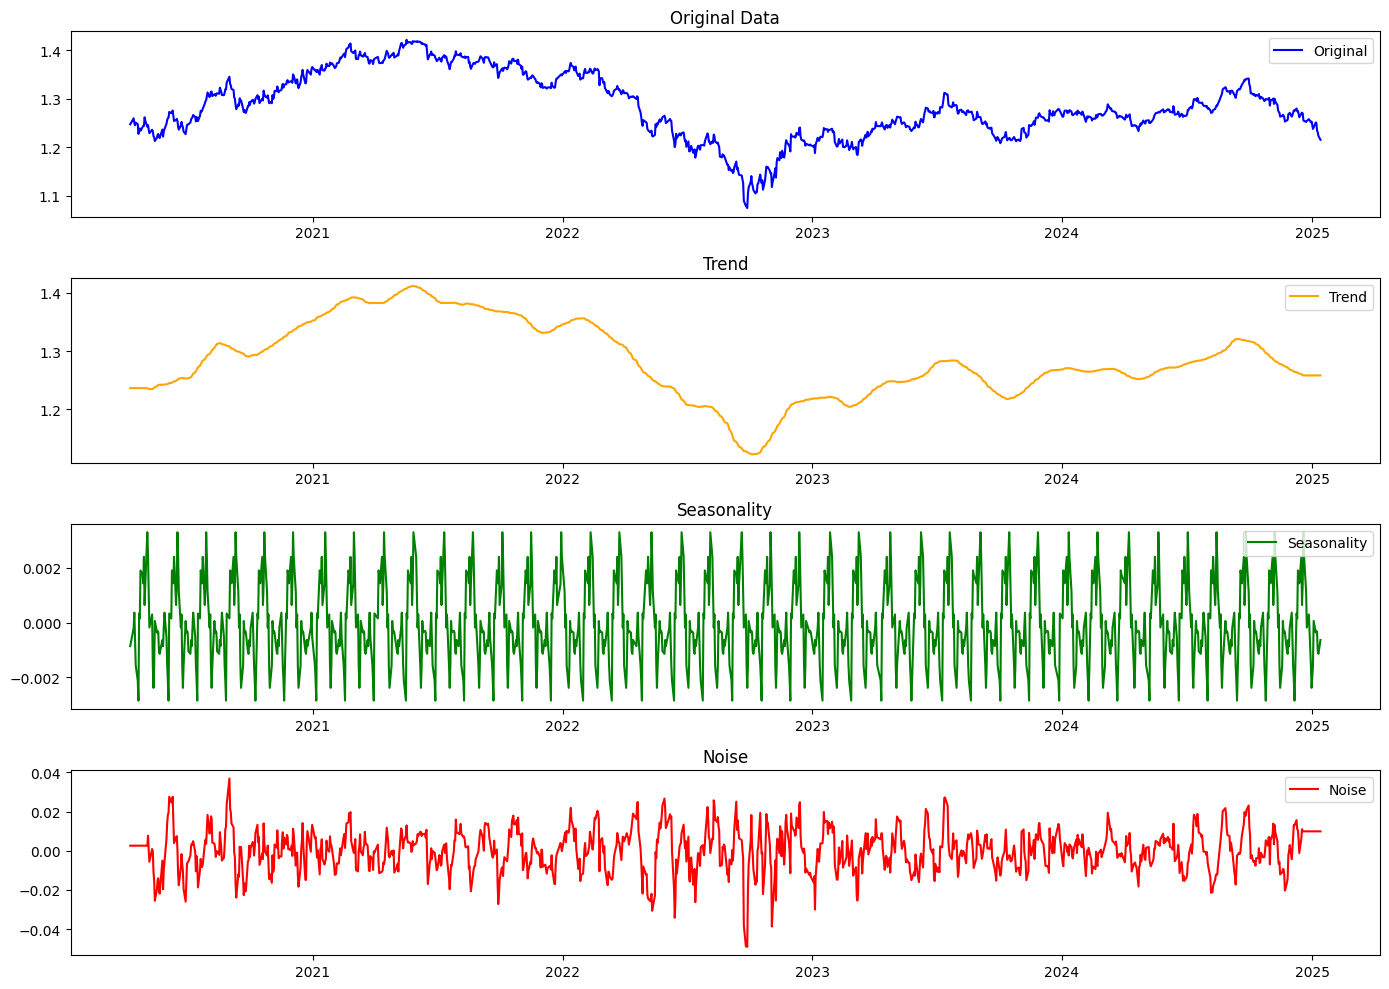

In [38]:
# General pre-process data for overall models
df = load_data()
df = pre_process_data(df)
plot_pre_processed_data(df)


# 3. Model based on each time instance (DNN)

### 3.1 Split the Test, validate and Train data 


In [39]:
# Training  and Target Features
features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day']
target = "Open"

# Split data 
u_train, u_validate, u_test = split_train_validate_test(df, train_percent=.7, validate_percent=0.15, test_percent=.15)

### 3.2 Scale the features and target

In [40]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale train, validate, and test sets
# Feature and target scaling on Training data 
train = pd.DataFrame()
feature_scaler.fit_transform(u_train[features])
target_scaler.fit_transform(u_train[[target]])

train['Date'] = u_train['Date']
train[features] = feature_scaler.transform(u_train[features])
train[target] = target_scaler.transform(u_train[[target]])

validate = pd.DataFrame()
validate['Date'] = u_validate['Date']
validate[features] = feature_scaler.transform(u_validate[features])
validate[target] = target_scaler.transform(u_validate[[target]])

test = pd.DataFrame()
test['Date'] = u_test['Date']
test[features] = feature_scaler.transform(u_test[features])
test[target] = target_scaler.transform(u_test[[target]])


### 3.3 Develop a base model

In [41]:
base_dnn_model = Sequential([
	layers.Dense(64, activation='relu', input_shape=(len(features),)),
	layers.Dense(1)  
])

base_dnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
base_dnn_history = base_dnn_model.fit(train[features], train[target], epochs=10, batch_size=1, validation_data=(validate[features], validate[target]), verbose=0)
base_dnn_model.summary()


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541 (6.02 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028 (4.02 KB)

### 3.4 Base model evaluation 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


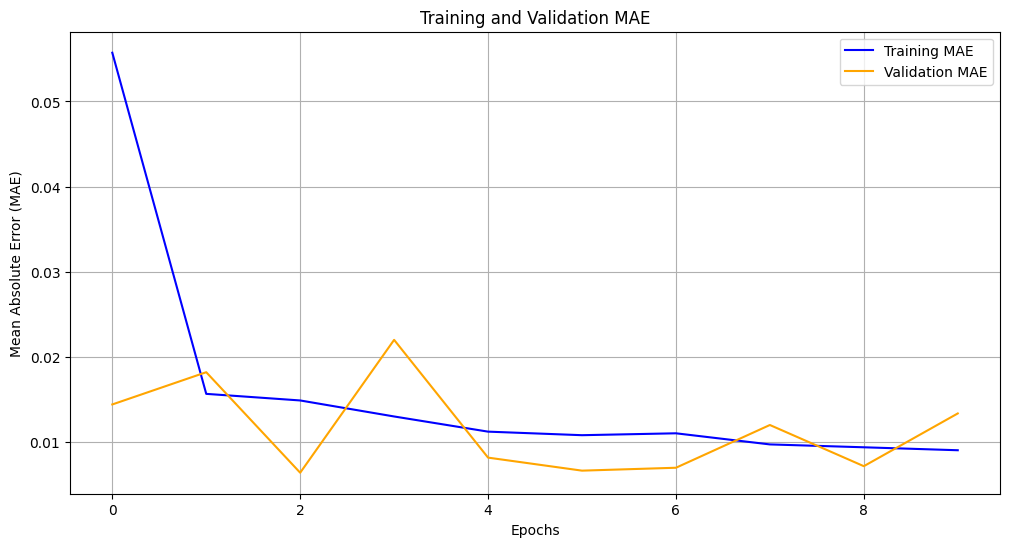

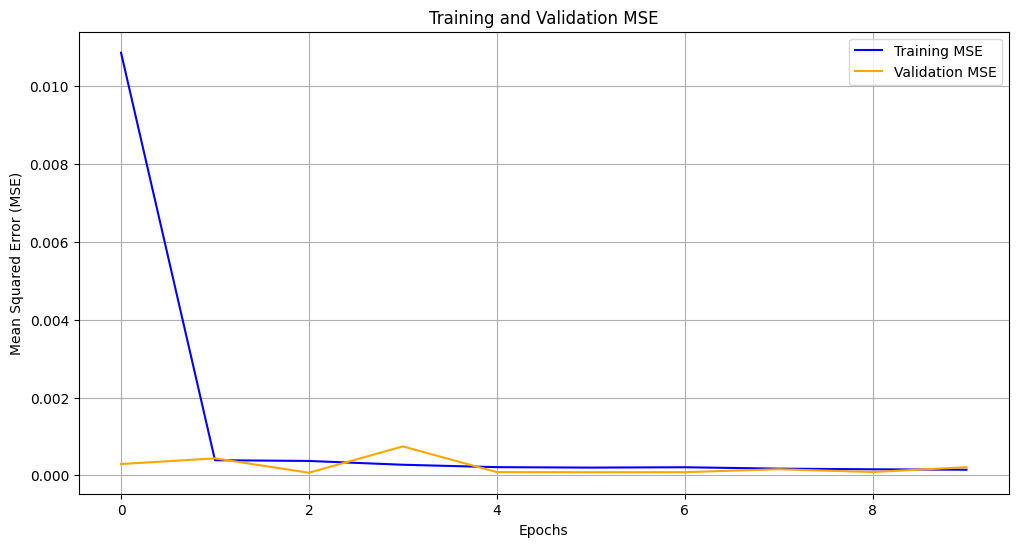

Mean Absolute Error (MAE): 0.018
Mean Squared Error (MSE): 0.001
R^2 Score: 0.820
Mean Absolute Percentage Error (MAPE): 13.080%


In [42]:
history = base_dnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

y_pred = base_dnn_model.predict(test[features])

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

dnn_base_metric = print_evaluation_metrics(test[[target]], y_pred)

### 3.5 Hyper-tuning

In [43]:
def build_model(hp):
    model = Sequential()
    num_layers_params = hp.Int('num_layers', 2, 4, step=5)

    i = 0
    unit_params = hp.Int(f'units_{i}', min_value=64, max_value=128, step=32)
    model.add(layers.Dense(units=unit_params, activation="relu", input_dim=len(features)))
    for i in range(1, num_layers_params):  
        model.add(layers.Dense(units=unit_params, activation='relu'))

    model.add(layers.Dense(units=1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

    return model

tuner = kt.Hyperband(build_model, objective='val_mae', factor=3, directory='nn_cache', project_name='DNN_tuning')
tuner.search(train[features],train[target],  epochs=50, validation_data=(validate[features], validate[target]), verbose=0)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/DNN_tuning/tuner0.json


### 3.6 Build Hyper-tuned model

In [44]:
dnn_model = build_model(best_hps)
history = dnn_model.fit(train[features], train[target], epochs=10, validation_data=(validate[features], validate[target]), verbose=0)
dnn_model.summary()

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,613 (205.52 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,076 (137.02 KB)

### 3.6 Evaluate hyper-tuned model 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


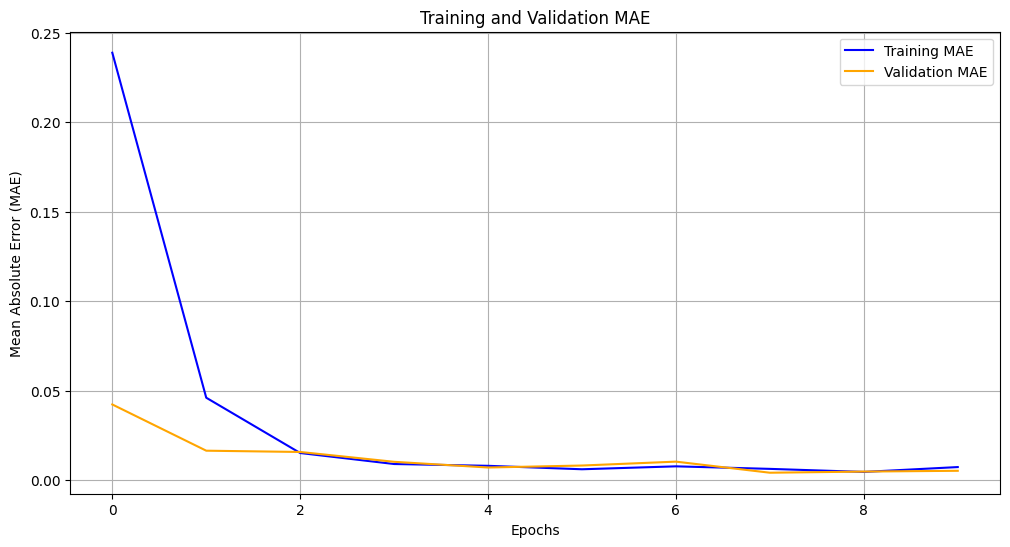

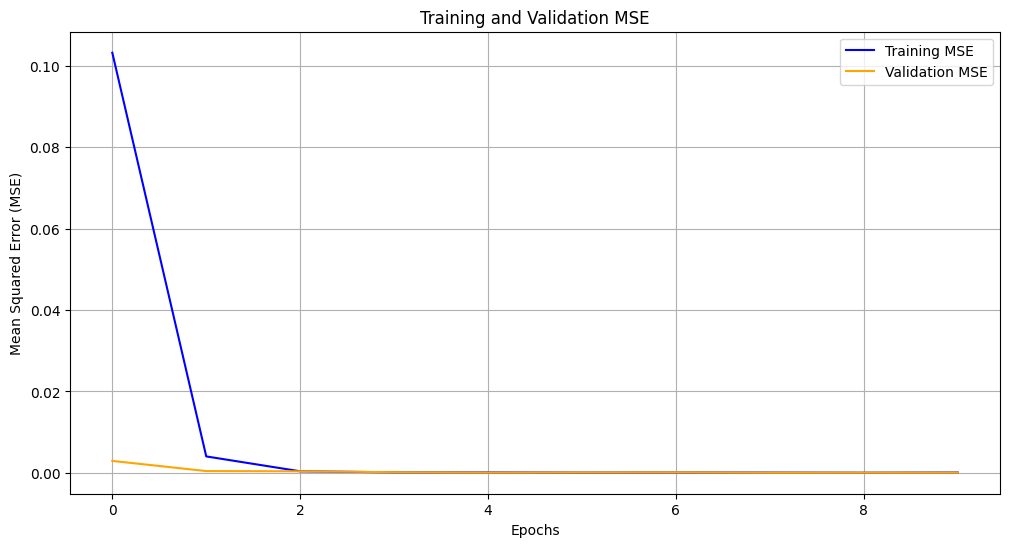

Mean Absolute Error (MAE): 0.008
Mean Squared Error (MSE): 0.000
R^2 Score: 0.908
Mean Absolute Percentage Error (MAPE): 12.734%


In [45]:
# Extract training and validation metrics
train_mae = history.history['mae']
train_mse = history.history['mse']
val_mae = history.history['val_mae']
val_mse = history.history['val_mse']

# Get model predictions on Test Data
y_pred = dnn_model.predict(test[features])
y_true = test[[target]]

# Plot the training and validation MAE and MSE 
plot_train_val_evaluation_history(train_mae, val_mae, "MAE")
plot_train_val_evaluation_history(train_mse, val_mse, "MSE")

# Print Evaluation Metrics
dnn_metric =  print_evaluation_metrics(y_true, y_pred)


### 3.7 Overview of whole predicted model 

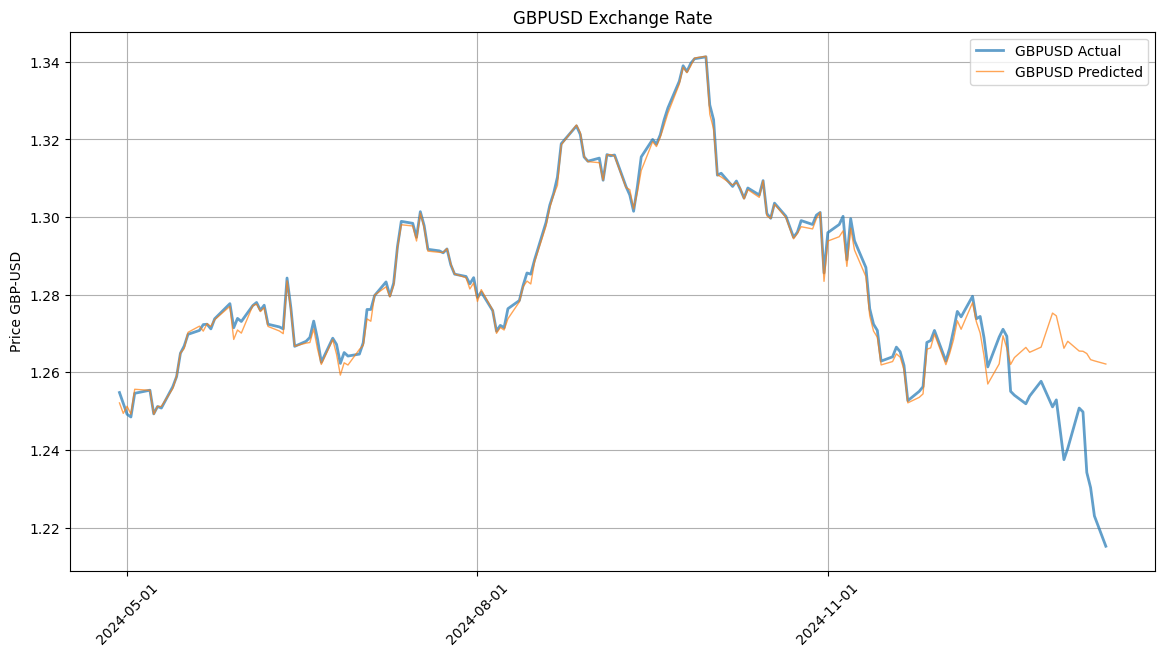

In [46]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values

actual_data = [test["Date"], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"], y_pred_unscaled, "GBPUSD Predicted"]

dnn_predicted = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 4 LSTM Neural Network (Time Series)

### 4.1 Implementing scaler on dataset

In [47]:
# Scaling the feature with updated scaler
# features = ['Trend', 'Seasonality', 'Noise', 'Week', 'Month', 'Day', 'Open']
features = ['Trend', 'Seasonality', 'Noise', 'Open']

feature_scaler = MinMaxScaler()
feature_scaler.fit(u_train[features])

# Creating a scaled dataframe
scaled_df = pd.DataFrame()

# Implementing Scaler on whole data  
scaled_df['Date'] = df['Date']
scaled_df[features] = feature_scaler.transform(df[features])
scaled_df[target] = target_scaler.transform(df[[target]])

### 4.2 Splitting & Generate Sequence

In [48]:
SEQ_LENGTH = 7

# Splitting the scaled data into train, validate, and test sets
train, validate, test = split_train_validate_test(scaled_df, train_percent=.7, validate_percent=0.15, test_percent=.15)

train_feature_seq, train_target_seq = time_sequence_generator(
    train[features].values, 
    train[target].values, 
    SEQ_LENGTH
)

validation_feature_seq, validation_target_seq = time_sequence_generator(
    validate[features].values, 
    validate[target].values, 
    SEQ_LENGTH)

test_feature_seq, test_target_seq = time_sequence_generator(
    test[features].values, 
    test[target].values, 
    SEQ_LENGTH
)


### 4.3 Train base model

In [49]:
lstm_base_model = Sequential([
    layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])),
    layers.LSTM(50, activation='relu'),
    layers.Dense(1)
])

lstm_base_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
base_lstm_history = lstm_base_model.fit(test_feature_seq, test_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), verbose=0)

lstm_base_model.summary()

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 7, 50)          │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,755 (366.23 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,504 (244.16 KB)

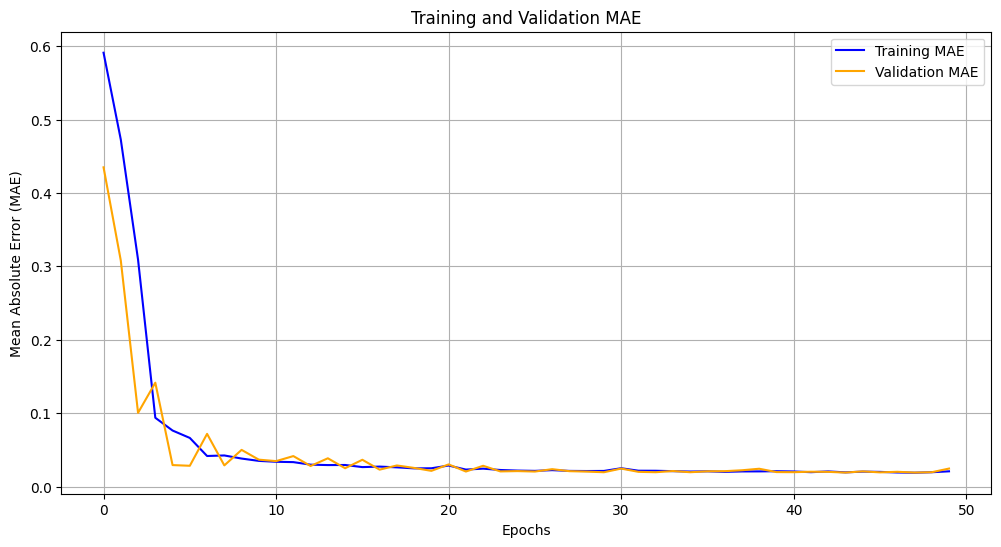

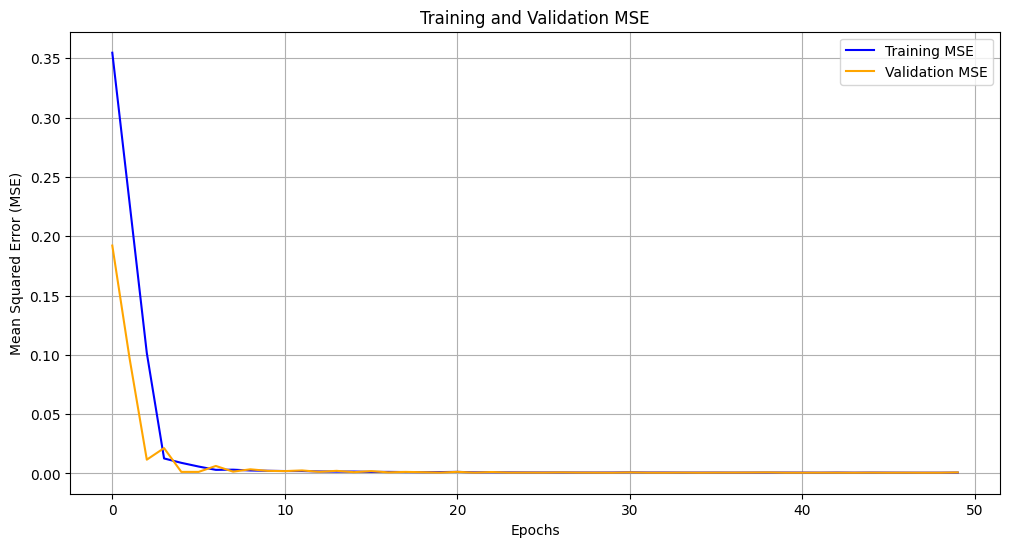

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Mean Absolute Error (MAE): 0.023
Mean Squared Error (MSE): 0.001
R^2 Score: 0.825
Mean Absolute Percentage Error (MAPE): 12.875%


In [50]:
history = base_lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
base_lstm_metric =  print_evaluation_metrics(y_true, y_pred)

### 4.4 Hyper-tune LSTM

In [51]:
import keras_tuner as kt 

def build_model(hp):
    model = keras.Sequential()


    for i in range(4): 
        model.add(layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=32, max_value=128, step=32),
            input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None,
            activation="relu",
            return_sequences=i < 3,
        ))

    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1))

    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=25,
    factor=12,
    directory='nn_cache',
    project_name='LSTM_tuning',
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True,
    monitor='val_mae'
)

tuner.search(
    train_feature_seq, train_target_seq,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=(validation_feature_seq, validation_target_seq),
    batch_size=12,
    verbose=0
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/LSTM_tuning/tuner0.json


### 4.5 Build Hyper-tuned LSTM Model

In [52]:
lstm_model = tuner.hypermodel.build(best_hps)
lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
# Train final model
lstm_model.summary()
lstm_history = lstm_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
    verbose=0
)

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 7, 96)          │        38,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 7, 128)         │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 7, 32)          │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,489 (779.25 KB)

 Trainable params: 199,489 (779.25 KB)

 Non-trainable params: 0 (0.00 B)

### 4.6 Evaluate the Hyper-tuned Data 

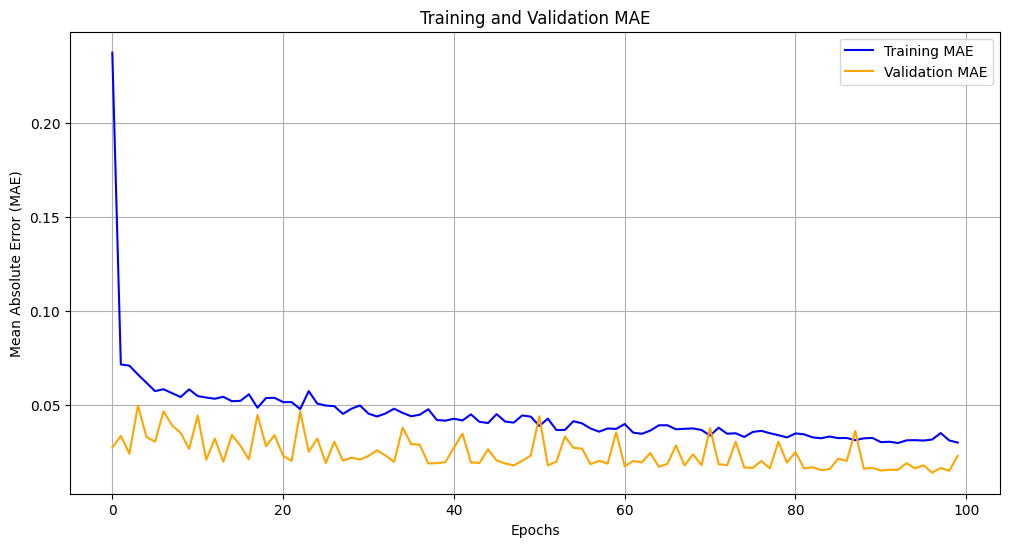

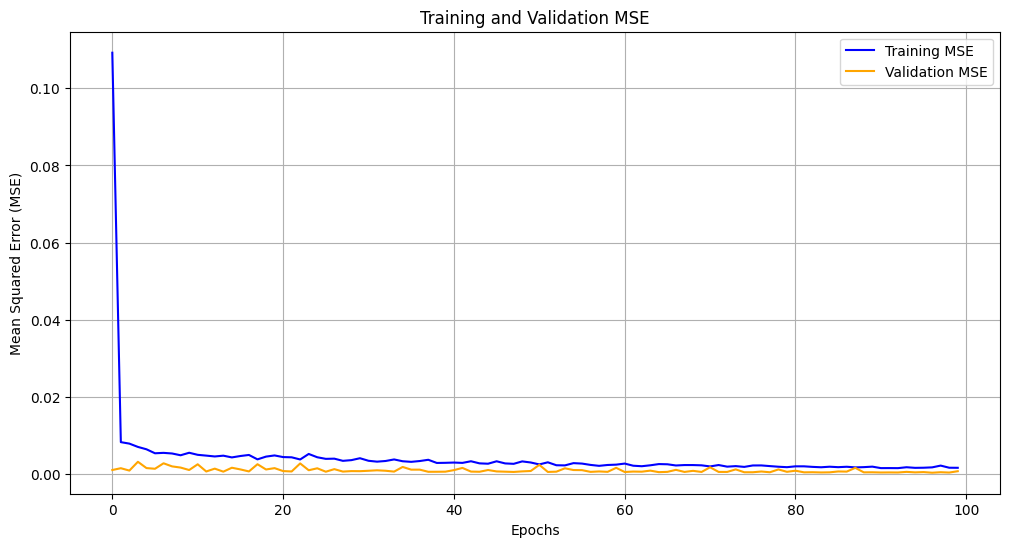

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Mean Absolute Error (MAE): 0.023
Mean Squared Error (MSE): 0.001
R^2 Score: 0.813
Mean Absolute Percentage Error (MAPE): 12.708%


In [53]:
history = lstm_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = lstm_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
lstm_metric =  print_evaluation_metrics(y_true, y_pred)

lstm_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

### 4.7 Plot the Actual, Predicted Value 

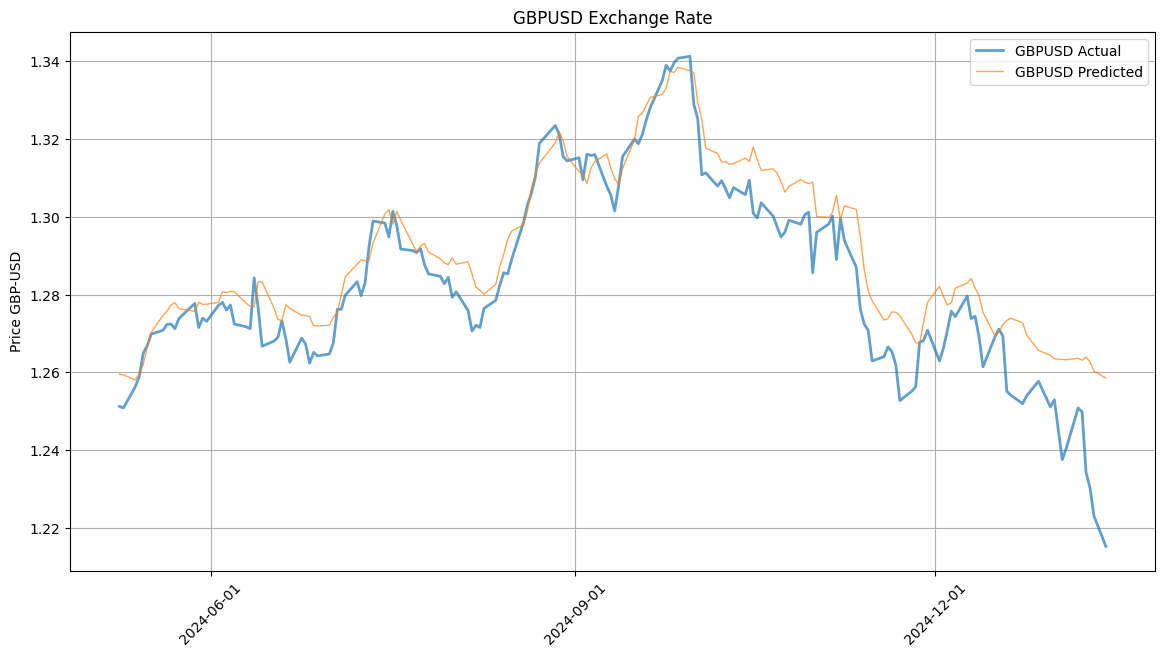

In [54]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lstm_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 5. Recurrent Model (Time Series)

### 5.1 Build base model

In [55]:
rnn_base_model = Sequential()
rnn_base_model.add(layers.SimpleRNN(units=64, activation='relu', input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
rnn_base_model.add(layers.Dense(1))
    
rnn_base_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

rnn_base_model.summary()

rnn_base_history = rnn_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq), verbose=0)

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2 Evaluate base model 

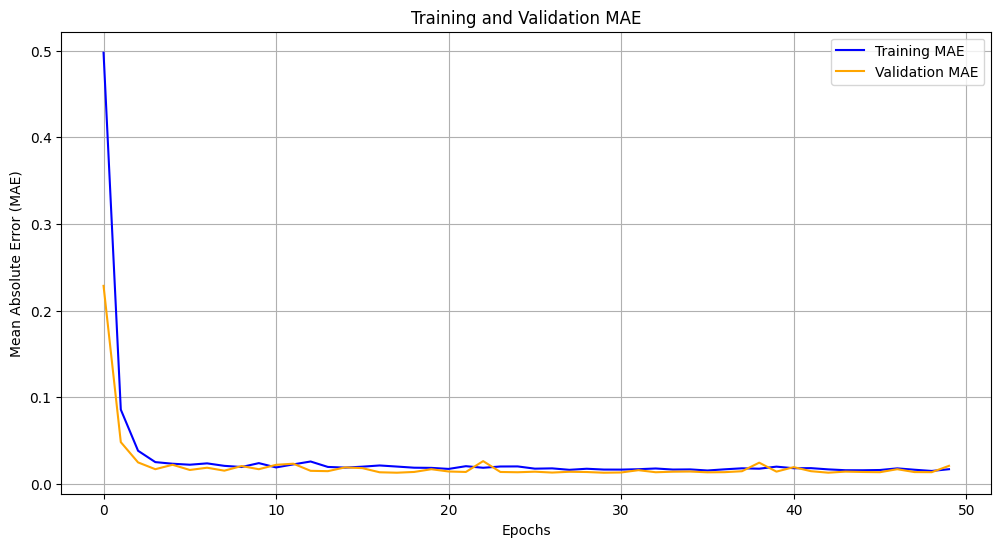

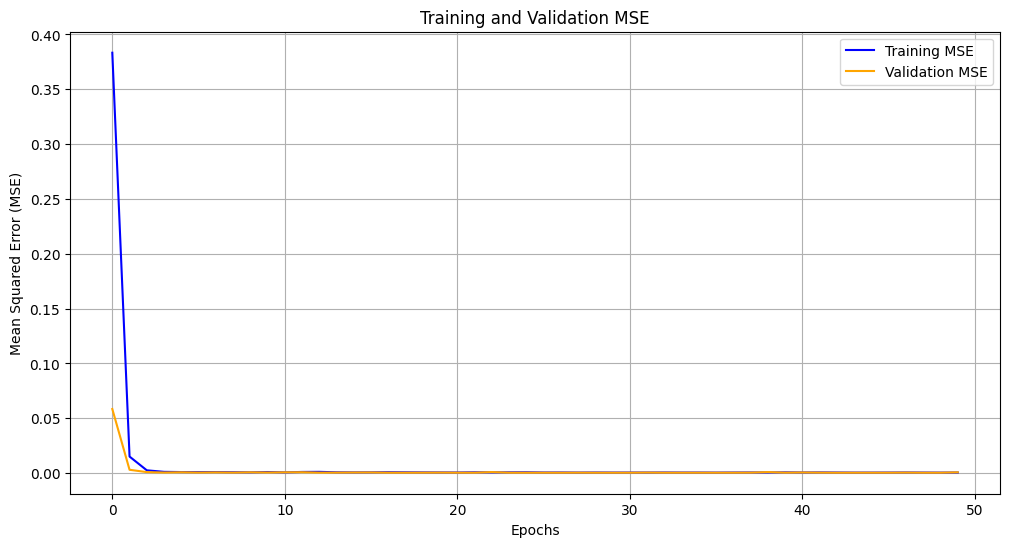

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Absolute Error (MAE): 0.027
Mean Squared Error (MSE): 0.001
R^2 Score: 0.806
Mean Absolute Percentage Error (MAPE): 12.480%


In [56]:
history = rnn_base_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']

plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_base_metric = print_evaluation_metrics(y_true, y_pred)

### 5.3 Hyper-tune RNN model

In [57]:
# Build RNN model
def build_model(hp):
	model = Sequential()
	num_layers = hp.Int('num_layers', min_value=1, max_value=4)
	for i in range(num_layers):
		model.add(layers.SimpleRNN(
			units=hp.Int(f'units_{i}', min_value=16, max_value=62, step=16),
			activation='relu',
			return_sequences=(i != num_layers - 1),
			input_shape=(train_feature_seq.shape[1], train_feature_seq.shape[2]) if i == 0 else None
		))
		model.add(layers.Dropout(0.1))
	
	model.add(layers.Dense(units=1)) 

	model.compile(
		optimizer=tf.keras.optimizers.Adam(
			learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
		),
		loss='mae',
		metrics=['mae', 'mse']
	)
	return model

# Hyperband tuner
tuner = kt.Hyperband(
	build_model,
	objective='val_mae',
	max_epochs=25,
	directory='nn_cache',
	project_name='RNN'
)

# Search for the best hyperparameters
tuner.search(train_feature_seq, train_target_seq, epochs=50, validation_data=(validation_feature_seq, validation_target_seq), batch_size=32, verbose=0)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/RNN/tuner0.json


### 5.4 Build Hyper-tune model 

In [58]:
rnn_model = tuner.hypermodel.build(best_hps)
rnn_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])
rnn_model.summary()
# Train final model
rnn_history = rnn_model.fit(
    train_feature_seq, train_target_seq,
    epochs=100,
    batch_size=50,
    validation_data=(validation_feature_seq, validation_target_seq),
    verbose=0
)

/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 48)             │         2,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593 (10.13 KB)

 Trainable params: 2,593 (10.13 KB)

 Non-trainable params: 0 (0.00 B)

### 5.4 Evaluate Hyper-tuned model

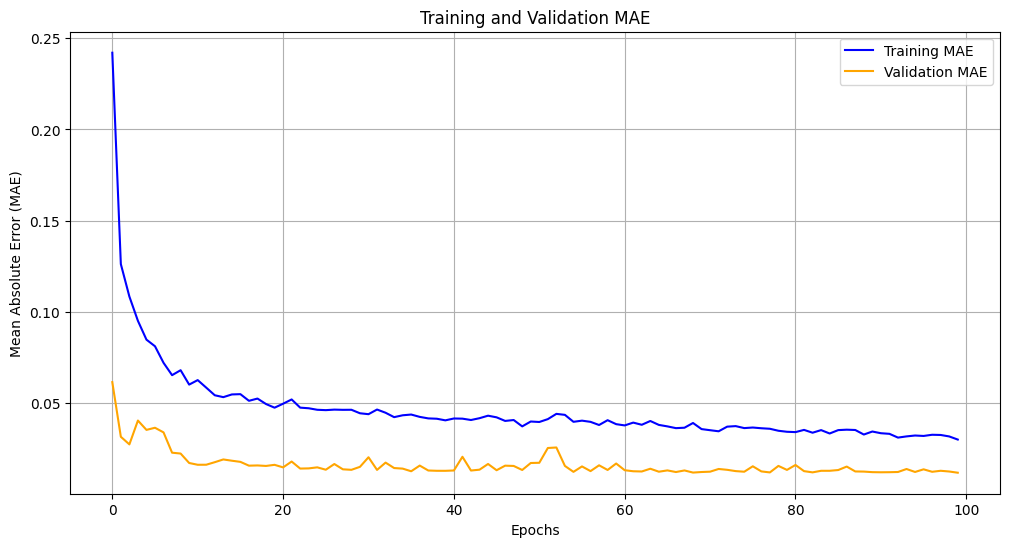

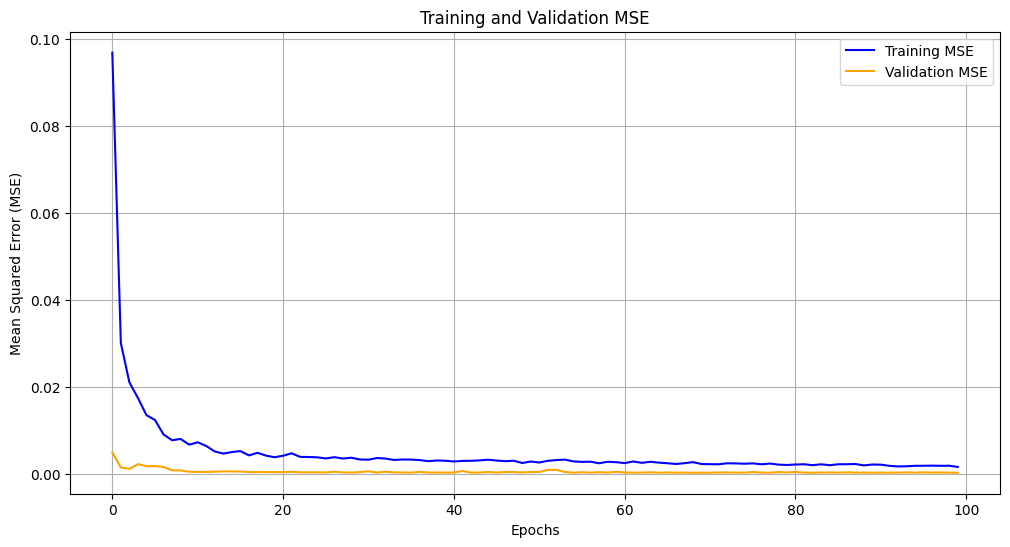

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Absolute Error (MAE): 0.015
Mean Squared Error (MSE): 0.000
R^2 Score: 0.905
Mean Absolute Percentage Error (MAPE): 12.133%


In [59]:
history = rnn_history.history

train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = rnn_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
rnn_metric =  print_evaluation_metrics(y_true, y_pred)


rnn_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

### 5.5 Plot the actual, predicted value

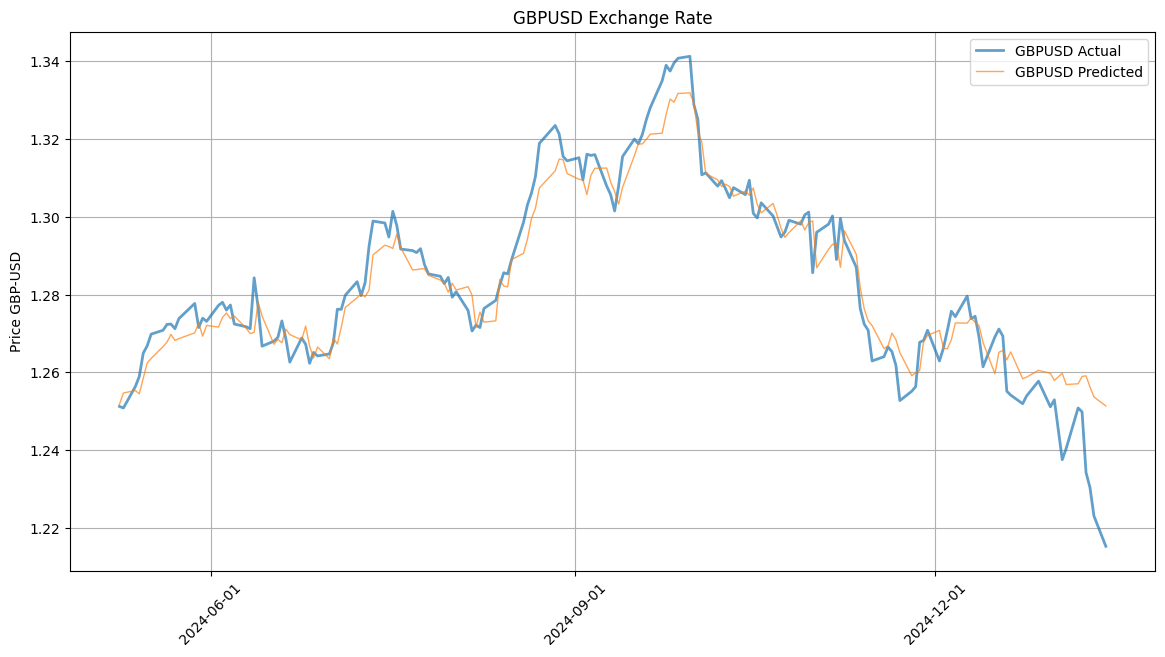

In [60]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

rnn_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# 6. CNN_LSTM Model (Regression)

### 6.1 Develop Base Model

In [61]:
cl_base_model = keras.Sequential()

cl_base_model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
cl_base_model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
cl_base_model.add(layers.LSTM(units=64, return_sequences=False))
cl_base_model.add(layers.Dense(units=1, activation='linear'))
cl_base_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

cl_base_history = cl_base_model.fit(train_feature_seq, train_target_seq, epochs=50, batch_size=32, validation_data=(validation_feature_seq, validation_target_seq), verbose=0)

cl_base_model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 5, 32)          │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,941 (296.65 KB)

 Trainable params: 25,313 (98.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,628 (197.77 KB)

### 6.2 Evaluate Base Model

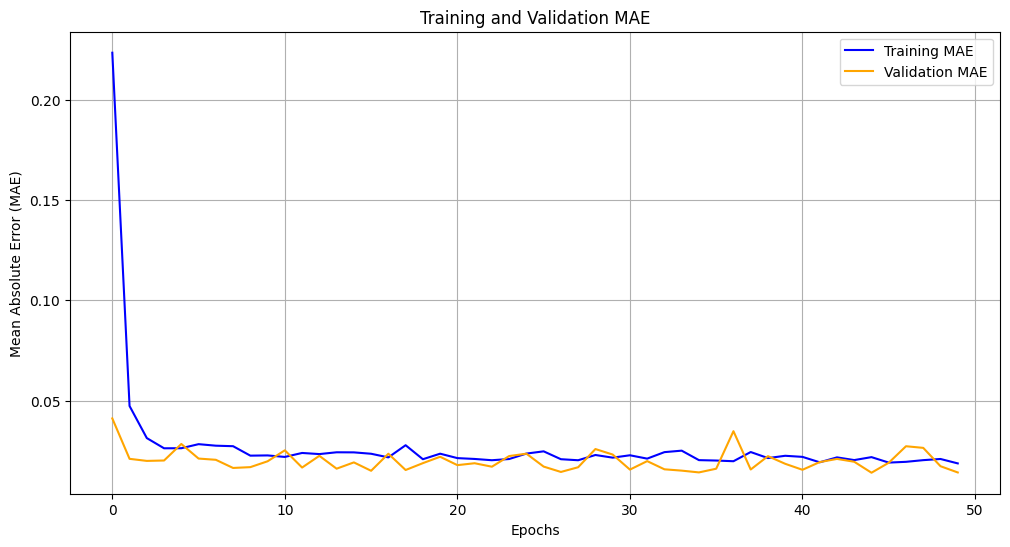

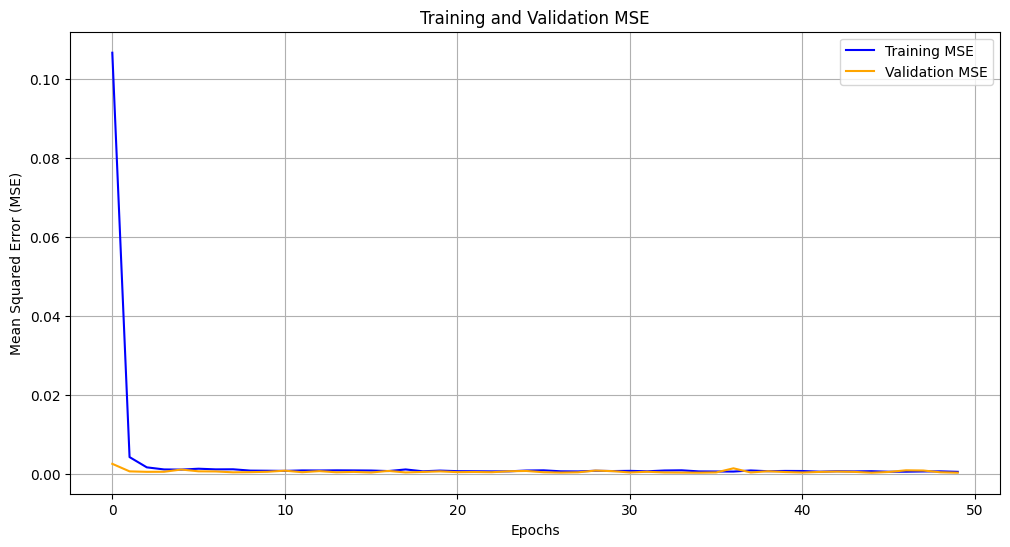

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Absolute Error (MAE): 0.016
Mean Squared Error (MSE): 0.001
R^2 Score: 0.888
Mean Absolute Percentage Error (MAPE): 12.290%


In [62]:
history = cl_base_history.history
train_mae, train_mse = history['mae'], history['mse']
validate_mae, validate_mse = history['val_mae'], history['val_mse']


plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

# Get model predictions on Test Data
y_pred = cl_base_model.predict(test_feature_seq)
y_true = pd.DataFrame(test_target_seq)

# Print Evaluation Metrics
cl_base_metric =  print_evaluation_metrics(y_true, y_pred)

### 6.3 Hyper-tune model

In [63]:
# Define LSTM-CNN Model with hyper-tuning for the number of layers
def build_lstm_cnn_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(train_feature_seq.shape[1], train_feature_seq.shape[2])))
    
    for i in range(hp.Int('num_cnn_layers', 1, 2)):
        model.add(layers.Conv1D(
            filters=hp.Int(f'cnn_filters_{i}', min_value=50, max_value=100, step=25),
            kernel_size=hp.Choice(f'cnn_kernel_size_{i}', values=[1, 2]),
            activation='relu'
        ))
    
    # Hyper-tuning number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 2)):
        model.add(layers.LSTM(
            units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=64, step=8),
            return_sequences=True if i < hp.get('num_lstm_layers') - 1 else False
        ))
        model.add(layers.Dropout(hp.Float('dropout_rate', 0.1, 0.2, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mae',
        metrics=['mae', 'mse']
    )
    return model

# Hyperband tuner
tuner = kt.Hyperband(
    build_lstm_cnn_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='nn_cache',
    project_name='lstm_cnn'
)

# Run Hyperband tuning
tuner.search(train_feature_seq, train_target_seq, validation_data=(validation_feature_seq, validation_target_seq), epochs=50, verbose=0)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from nn_cache/lstm_cnn/tuner0.json


In [64]:
lc_model = tuner.hypermodel.build(best_hps)
lc_model.compile(optimizer='adam', loss='mae', metrics=['mae', 'mse'])

# Train final model
lc_history = lc_model.fit(
    train_feature_seq, train_target_seq,
    epochs=200,
    batch_size=16,
    validation_data=(validation_feature_seq, validation_target_seq),
    verbose=0 
)

lc_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 7, 100)         │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 56)             │        35,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,177 (418.66 KB)

 Trainable params: 35,725 (139.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,452 (279.11 KB)

### 6.4 Evaluate the Hyper-tuned model

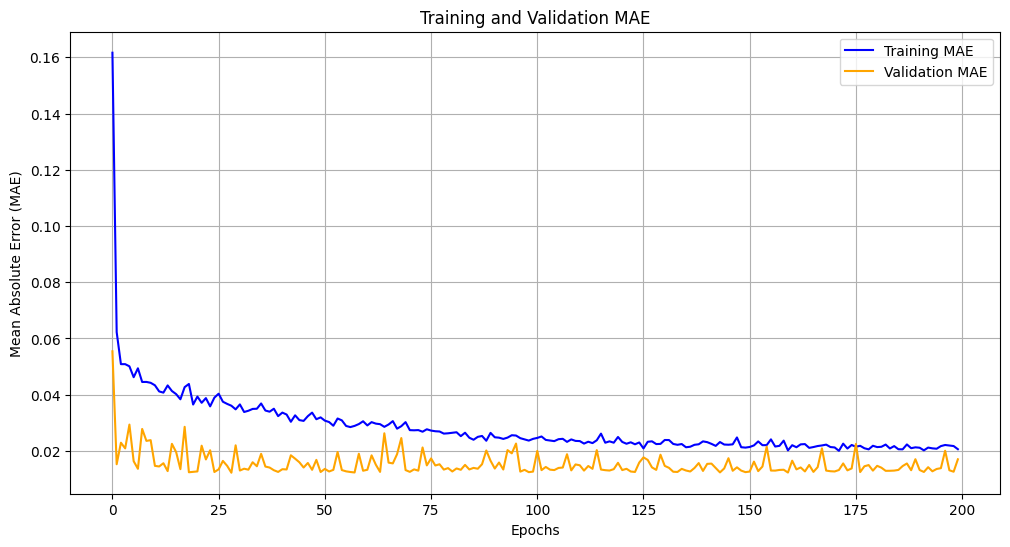

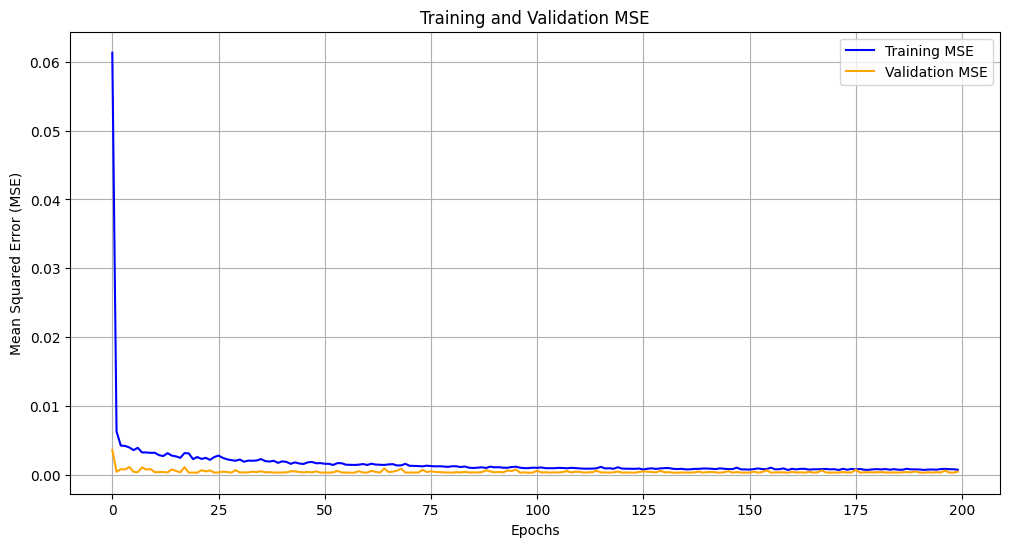

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Absolute Error (MAE): 0.017
Mean Squared Error (MSE): 0.001
R^2 Score: 0.879
Mean Absolute Percentage Error (MAPE): 12.662%


In [65]:
def evaluate_model(history, model, test_features, test_target):
	# Extract training and validation metrics
	train_mae, train_mse = history['mae'], history['mse']
	validate_mae, validate_mse = history['val_mae'], history['val_mse']

	# Plot the training and validation MAE and MSE
	plot_train_val_evaluation_history(train_mae, validate_mae, "MAE")
	plot_train_val_evaluation_history(train_mse, validate_mse, "MSE")

	# Get model predictions on Test Data
	y_pred = model.predict(test_features)
	y_true = pd.DataFrame(test_target)

	# Print Evaluation Metrics
	metric  = print_evaluation_metrics(y_true, y_pred)

	return metric, y_pred

lc_metric, y_pred =  evaluate_model(lc_history.history, lc_model, test_feature_seq, test_target_seq)
lc_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


### 6.5 Plot the actual, predicted value

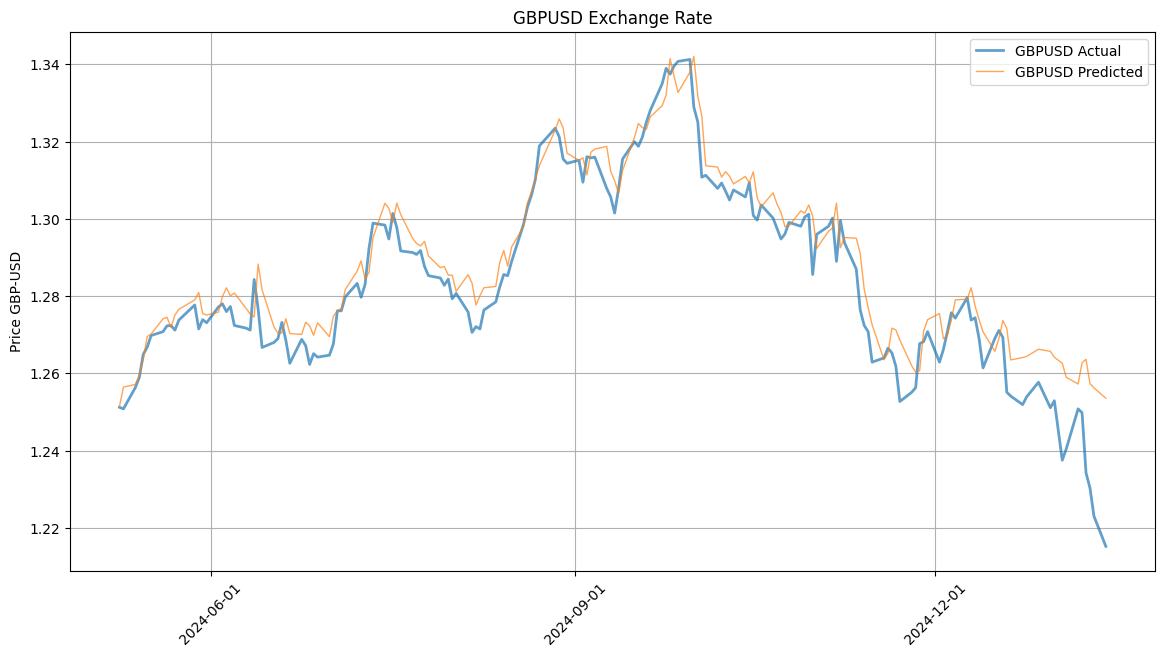

In [66]:
y_pred_unscaled = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test_unscaled = u_test[target].values[7:]

actual_data = [test["Date"][7:], y_test_unscaled, "GBPUSD Actual"]
predicted_data = [test["Date"][7:], y_pred_unscaled, "GBPUSD Predicted"]

lc_pred = y_pred_unscaled

plot_gbp_usd([actual_data, predicted_data])

# Plot all metrics in a single table

In [67]:
metrics = [[dnn_base_metric, "DNN base model"], [dnn_metric, "DNN Hyper-tuned model" ],[base_lstm_metric, "LSTM base model"], [lstm_metric, "LSTM hyper-tuned model" ],[rnn_base_metric, "RNN base model"], [rnn_metric, "RNN Hyper-tuned model"], [cl_base_metric, "Ensemble base model"], [lc_metric, "Ensemble Hyper-tuned model"]]  

df = pd.DataFrame()
# Initialize the DataFrame with appropriate columns
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R Square', 'MAPE'])

# Populate the DataFrame with metrics
for i, m in enumerate(metrics):
	df = pd.concat([df, pd.DataFrame([{
		'Model': m[1],
		'MAE': round(m[0]['MAE'], 5),
		'MSE': round(m[0]['MSE'], 5),
		'R Square': round(m[0]['R Square'], 5),
		'MAPE': round(m[0]['MAPE'], 5)
	}])], ignore_index=True)

df.reset_index(drop=True, inplace=True)
df
        

/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_64913/2461053800.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,Model,MAE,MSE,R Square,MAPE
0,DNN base model,0.01839,0.00090,0.82022,13.07996
1,DNN Hyper-tuned model,0.00843,0.00046,0.90821,12.73435
2,LSTM base model,0.02252,0.00085,0.82547,12.87530
3,LSTM hyper-tuned model,0.02269,0.00091,0.81348,12.70785
4,RNN base model,0.02692,0.00094,0.80644,12.47989
5,RNN Hyper-tuned model,0.01526,0.00046,0.90504,12.13283
6,Ensemble base model,0.01599,0.00054,0.88837,12.29020
7,Ensemble Hyper-tuned model,0.01725,0.00059,0.87889,12.66189


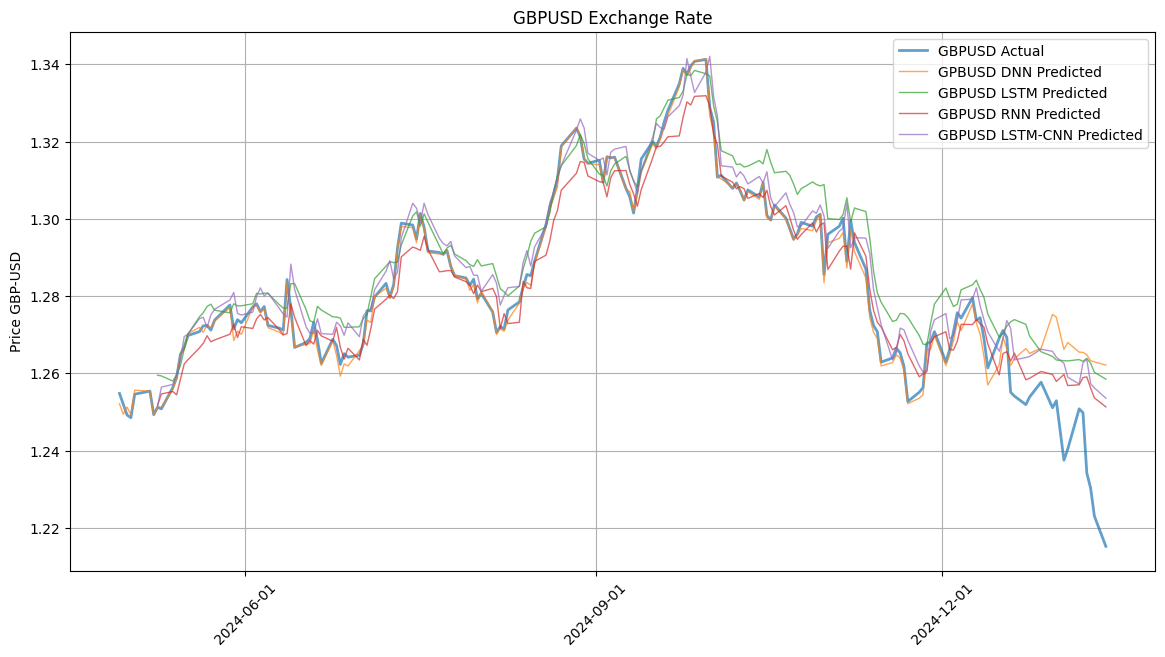

In [68]:
plot_gbp_usd([
	[test['Date'], u_test['Open'], "GBPUSD Actual"],
	[test['Date'], dnn_predicted, "GPBUSD DNN Predicted"],
	[test['Date'][7:], lstm_pred, "GBPUSD LSTM Predicted"],
	[test['Date'][7:], rnn_pred, "GBPUSD RNN Predicted"],
	[test['Date'][7:], lc_pred, "GBPUSD LSTM-CNN Predicted"],
])
